In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
from lib.vllm import start_vllm

vllm = await start_vllm(
    "NousResearch/Hermes-2-Theta-Llama-3-8B",
    env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
    block_size=32,
    disable_log_requests=True,
    # enable_prefix_caching=True,
    enforce_eager=True,
    gpu_memory_utilization=0.999,
    max_model_len=16384,
    max_num_seqs=4096,
    max_num_batched_tokens=16384 * 8,
    return_tokens_as_token_ids=True,
    swap_space=8,
)

$ vllm serve NousResearch/Hermes-2-Theta-Llama-3-8B --block-size=32 --disable-log-requests --enforce-eager --gpu-memory-utilization=0.999 --max-model-len=16384 --max-num-seqs=4096 --max-num-batched-tokens=131072 --return-tokens-as-token-ids --swap-space=8 --port=8003 --api-key=default
INFO 12-03 21:11:36 api_server.py:528] vLLM API server version 0.6.3.post1
INFO 12-03 21:11:36 api_server.py:529] args: Namespace(subparser='serve', model_tag='NousResearch/Hermes-2-Theta-Llama-3-8B', config='', host=None, port=8003, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert_reqs=0, root_path=None, middleware=[], return_tokens_as_token_ids=True, disable_frontend_multiprocessing=False, enable_auto_tool_choice=False, tool_call_parser=None, tool_parser_plugin='',

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.56it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:00<00:01,  1.93it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.58it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.48it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.63it/s]



INFO 12-03 21:11:51 model_runner.py:1067] Loading model weights took 14.9595 GB
INFO 12-03 21:11:57 gpu_executor.py:122] # GPU blocks: 9747, # CPU blocks: 2048
INFO 12-03 21:11:57 gpu_executor.py:126] Maximum concurrency for 16384 tokens per request: 19.04x
INFO 12-03 21:12:01 api_server.py:232] vLLM to use /tmp/tmp4yua16u4 as PROMETHEUS_MULTIPROC_DIR
WARNING 12-03 21:12:01 serving_embedding.py:199] embedding_mode is False. Embedding API will not work.
INFO 12-03 21:12:01 launcher.py:19] Available routes are:
INFO 12-03 21:12:01 launcher.py:27] Route: /openapi.json, Methods: HEAD, GET
INFO 12-03 21:12:01 launcher.py:27] Route: /docs, Methods: HEAD, GET
INFO 12-03 21:12:01 launcher.py:27] Route: /docs/oauth2-redirect, Methods: HEAD, GET
INFO 12-03 21:12:01 launcher.py:27] Route: /redoc, Methods: HEAD, GET
INFO 12-03 21:12:01 launcher.py:27] Route: /health, Methods: GET
INFO 12-03 21:12:01 launcher.py:27] Route: /tokenize, Methods: POST
INFO 12-03 21:12:01 launcher.py:27] Route: /detoken

INFO:     Started server process [21344]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on socket ('0.0.0.0', 8003) (Press CTRL+C to quit)


INFO:     127.0.0.1:36894 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


In [20]:
chat_completion = await vllm.client.chat.completions.create(
    messages=[{"role": "user", "content": "What is the capital of France?"}],
    model="NousResearch/Hermes-2-Theta-Llama-3-8B",
    logprobs=True,
    stop=["."],
    extra_body={
        "guided_regex": r"The capital of France is \w+\.",
        "skip_special_tokens": False,
    },
)

In [23]:
chat_completion.choices[0].logprobs.content

[ChatCompletionTokenLogprob(token='token_id:791', bytes=[84, 104, 101], logprob=0.0, top_logprobs=[]),
 ChatCompletionTokenLogprob(token='token_id:6864', bytes=[32, 99, 97, 112, 105, 116, 97, 108], logprob=0.0, top_logprobs=[]),
 ChatCompletionTokenLogprob(token='token_id:315', bytes=[32, 111, 102], logprob=0.0, top_logprobs=[]),
 ChatCompletionTokenLogprob(token='token_id:9822', bytes=[32, 70, 114, 97, 110, 99, 101], logprob=0.0, top_logprobs=[]),
 ChatCompletionTokenLogprob(token='token_id:374', bytes=[32, 105, 115], logprob=0.0, top_logprobs=[]),
 ChatCompletionTokenLogprob(token='token_id:12366', bytes=[32, 80, 97, 114, 105, 115], logprob=0.0, top_logprobs=[]),
 ChatCompletionTokenLogprob(token='token_id:13', bytes=[46], logprob=0.0, top_logprobs=[])]

In [25]:
from lib.utils import get_token

get_token(chat_completion.choices[0].logprobs.content[-2])

' Paris'

In [ ]:
vllm.process.terminate()

In [ ]:
await vllm.client.completions.create(
    model="NousResearch/Hermes-2-Theta-Llama-3-8B",
    # prompt="<|begin_of_text|><|im_start|>user\n",
    prompt=[128000, 128002, 882],
    max_tokens=1,
    extra_body={
        "prompt_logprobs": 1,
    },
)

In [3]:
import asyncio
from lib.clue import Clue, DeductiveSolver
from lib.rl.episode import Episode, EpisodeCompletion
from lib.rl.ppo import PPOLoss
from lib.rl.recipe import ComponentConfig, TuneRecipeConfig
from lib.rl.trainer import Trainer
from lib.utils import return_exception
import torch
from torchtune.models.llama3_1 import llama3_1_8b
from torchtune.training.metric_logging import WandBLogger
import random
import re


@return_exception
def sample_random_episode() -> Episode:
    game = Clue(
        num_players=3,
        elements={
            "suspect": random.sample(Clue.suspects, k=3),
            "weapon": random.sample(Clue.weapons, k=3),
            "room": random.sample(Clue.rooms, k=3),
            # "motive": random.sample(Clue.motives, k=3),
            # "time": Clue.get_times("21:00", "03:00", "1h"),
        },
    )
    game.play(
        deductive_solver=DeductiveSolver(
            # note_cards_in_hand=False,
            # note_responses_to_suggestions=False,
            # note_cards_that_players_do_not_have=False,
            # check_unique_card_placement_constraints=False,
            # check_player_hand_size_constraints=False,
            check_solution_has_one_and_only_one_card_per_element=False,
            check_one_of_constraints=False,
            check_inverse_one_of_constraints=False,
            merge_and_check_disjoint_inverse_one_of_constraints=False,
            exhaustively_test_possible_assignments=False,
        ),
        cp_solver_max_solve_time_per_turn=0.01,
        check_cp_solver_grid=False,
        check_if_deductive_solver_and_cp_solver_grids_match=False,
        print_playthrough=False,
    )
    prompt, follow_up, solution = game.get_prompt_and_follow_up_and_solution()

    async def reward_completion(completion: EpisodeCompletion) -> EpisodeCompletion:
        if len(completion.messages) == 2:
            follow_up_completion = await completion.follow_up(
                messages=[
                    {"role": "user", "content": follow_up},
                ]
            )
        else:
            follow_up_completion = completion
        answer = follow_up_completion.last_assistant_message.get("content")
        assert isinstance(answer, str)
        completion.reward = sum(
            [
                bool(
                    re.search(
                        f"{key}: {value}",
                        answer,
                        re.IGNORECASE,
                    )
                )
                for key, value in solution.items()
            ]
        ) / len(solution)
        return completion

    async def on_sample(completions: list[EpisodeCompletion]) -> None:
        for completion in await asyncio.gather(
            *[reward_completion(completion) for completion in completions]
        ):
            completion.commit()

    return Episode(
        messages=[{"role": "user", "content": prompt}],
        on_sample=on_sample,
    )


def train_episodes():
    while True:
        yield sample_random_episode()


trainer = Trainer(
    base_model="NousResearch/Hermes-2-Theta-Llama-3-8B",
    output_dir="./models/rl2",
    samples_per_episode=27,
    branch_factor=3,
    sample_probability_power=1 / 3,
    train_episodes=train_episodes(),
    episodes_per_iteration=128 * torch.cuda.device_count(),
    patience_per_sample=1 / 27,
    sampling_kwargs={
        "max_tokens": 2048,
    },
    max_mask_sequence_batch_size=1,
    val_episodes=(
        sample_random_episode() for _ in range(32 * torch.cuda.device_count())
    ),
    val_samples_per_episode=3,
    torchrun_kwargs=dict(nnodes=1, nproc_per_node=torch.cuda.device_count()),
    tune_model=llama3_1_8b,
    tune_model_type="LLAMA3",
    tune_recipe_config=TuneRecipeConfig(
        seed=42,
        shuffle=False,
        num_output_chunks=4,
        resume_from_checkpoint=False,
        batch_size=2,
        epochs=1,
        metric_logger=ComponentConfig(
            WandBLogger,
        ),
        optimizer=ComponentConfig(
            "torch.optim.AdamW",
            # "bitsandbytes.optim.PagedAdamW8bit",
            # "bitsandbytes.optim.AdamW",
            # params=PLACEHOLDER,
            lr=5e-6,
            fused=True,
        ),
        loss=ComponentConfig(
            PPOLoss,
            policy_coef=1.0,
            clip_epsilon=0.2,
            entropy_coef=0.02,
            kl_coef=0.0,
            weighted_ce_coef=0.0,
            weighted_entropy_coef=0.0,
            weighted_kl_coef=0.0,
            normalize_values=False,
            normalize_advantages=False,
        ),
        compile=False,
        optimizer_in_bwd=False,
        gradient_accumulation_steps=1,
        enable_activation_checkpointing=True,
        enable_activation_offloading=False,
        custom_sharded_layers=["tok_embeddings", "output"],
        log_every_n_steps=1,
        log_peak_memory_stats=True,
    ),
    # tune_run=False,
    tune_sequence_length=8192,
    # vllm_env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
    vllm_kwargs=dict(
        block_size=32,
        disable_log_requests=True,
        enable_prefix_caching=True,
        enforce_eager=True,
        gpu_memory_utilization=0.95,
        # max_model_len=16384,
        max_num_seqs=512 * torch.cuda.device_count(),
        max_num_batched_tokens=8192 * 4,
        swap_space=8,
        # scheduling_policy="priority",
        # tensor_parallel_size=torch.cuda.device_count() // 8,
    ),
    vllm_max_concurrent_samples=512 * torch.cuda.device_count(),
    vllm_min_time_between_requests=0.0,
    vllm_num=torch.cuda.device_count(),
    vllm_timeout=120 + 15 * torch.cuda.device_count(),
)

Resuming from /home/ubuntu/atreides/experiments/models/rl2/0001
INFO 12-03 21:39:06 llm_engine.py:237] Initializing an LLM engine (v0.6.3.post1) with config: model='NousResearch/Hermes-2-Theta-Llama-3-8B', speculative_config=None, tokenizer='NousResearch/Hermes-2-Theta-Llama-3-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=NousResearch/Hermes-2-Thet

In [26]:
tokens = trainer.tokenizer.encode(
    [{"role": "assistant", "content": "!"}],
    # remove_bos=True,
    # first_message_is_continuation=True,
    continue_final_message=False,
)

zero_idx = (tokens == 0).nonzero()[0]
new_tokens = torch.cat([tokens[:zero_idx], torch.tensor([1, 1]), tokens[zero_idx+1:]])
new_tokens

tensor([128000, 128002,  78191,    198,      1,      1, 128003,    198])

In [13]:
type(trainer.tokenizer.llm.get_tokenizer()._tokenizer)

tokenizers.Tokenizer

In [14]:
trainer.tokenizer.llm.get_tokenizer().convert_ids_to_tokens([791, 6864])

['The', 'Ġcapital']

In [11]:
trainer.tokenizer.llm.get_tokenizer().decode  # ([791, 6864])

<bound method PreTrainedTokenizerBase.decode of CachedPreTrainedTokenizerFast(name_or_path='NousResearch/Hermes-2-Theta-Llama-3-8B', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='left', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|im_end|>', 'pad_token': '<|end_of_text|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<tool_call>", rstrip=False, lstrip=False, single_word=False, normalized=False

In [1]:
16384 // 2

8192

In [4]:
explore_result = await trainer.explore()

Starting 1 vLLM servers...
$ vllm serve NousResearch/Hermes-2-Theta-Llama-3-8B --port=8002 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-num-seqs=512 --max-num-batched-tokens=32768 --swap-space=8 --api-key=default
INFO 12-03 18:49:14 api_server.py:528] vLLM API server version 0.6.3.post1
INFO 12-03 18:49:14 api_server.py:529] args: Namespace(subparser='serve', model_tag='NousResearch/Hermes-2-Theta-Llama-3-8B', config='', host=None, port=8002, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=None, ssl_cert_reqs=0, root_path=None, middleware=[], return_tokens_as_token_ids=False, disable_frontend_multiprocessing=False, enable_auto_tool_choice=False, tool_call_parser=None, tool_parser_plugin='', m

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  4.20it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:01<00:01,  1.59it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:02<00:00,  1.27it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.17it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:03<00:00,  1.30it/s]



INFO 12-03 18:49:31 model_runner.py:1067] Loading model weights took 14.9595 GB
INFO 12-03 18:49:32 gpu_executor.py:122] # GPU blocks: 14333, # CPU blocks: 2048
INFO 12-03 18:49:32 gpu_executor.py:126] Maximum concurrency for 8192 tokens per request: 55.99x
INFO 12-03 18:49:37 api_server.py:232] vLLM to use /tmp/tmpxmysilan as PROMETHEUS_MULTIPROC_DIR
WARNING 12-03 18:49:37 serving_embedding.py:199] embedding_mode is False. Embedding API will not work.
INFO 12-03 18:49:37 launcher.py:19] Available routes are:
INFO 12-03 18:49:37 launcher.py:27] Route: /openapi.json, Methods: GET, HEAD
INFO 12-03 18:49:37 launcher.py:27] Route: /docs, Methods: GET, HEAD
INFO 12-03 18:49:37 launcher.py:27] Route: /docs/oauth2-redirect, Methods: GET, HEAD
INFO 12-03 18:49:37 launcher.py:27] Route: /redoc, Methods: GET, HEAD
INFO 12-03 18:49:37 launcher.py:27] Route: /health, Methods: GET
INFO 12-03 18:49:37 launcher.py:27] Route: /tokenize, Methods: POST
INFO 12-03 18:49:37 launcher.py:27] Route: /detoken

INFO:     Started server process [12293]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on socket ('0.0.0.0', 8002) (Press CTRL+C to quit)


INFO:     127.0.0.1:49442 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


explore:   0%|          | 0/128 [00:00<?, ?episode/s]

Early stopping exploration due to expired patience (18.115199999989372 remaining samples x 0.037037037037037035 patience per sample = 0.6709333333329397 seconds)


In [7]:
trainer.tune_run = True

In [17]:
trainer.tune_recipe_config.dtype = "bf16"

In [40]:
explore_result.tensors()["values"][
    ~torch.isnan(explore_result.tensors()["values"])
].mean()

tensor(-3.2450e-09)

In [41]:
trainer.tune_recipe_config.optimizer.lr = 1e-6

In [47]:
trainer.tune_recipe_config.num_output_chunks = 1

In [49]:
trainer.tune_recipe_config.batch_size = 1

In [51]:
trainer.tune_run = False

/home/ubuntu/atreides/.venv/lib/python3.12/site-packages/wandb/sdk/wandb_run.py:2388: UserWarning: Run (rqbpj3ze) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
  0%|          | 0/93 [04:03<?, ?it/s]
DEBUG:torchtune.utils._logging:Training is not distributed. If you want to train on multiple GPUs and are using the tune CLI, specify --nnodes 1 and --nproc_per_node [num_gpus]
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 1
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/atreides/experiments/models/rl2/0001
  checkpoint_files:
  - /home/ubuntu/atreides/experiments/models/rl2/0001/hf_model_0003_0.pt
  - /home/ubuntu/atreides/experiments/models/rl2/0001/hf_model_0004_0.pt
  - /home/ubuntu/atreides/experiments/models/rl2/0001/hf_model_000

INFO:torchtune.utils._logging:Logging /home/ubuntu/atreides/experiments/models/rl2/0001/torchtune_config.yaml to W&B under Files
INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 2.68 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 15.05 GiB
	GPU peak memory reserved: 15.17 GiB
	GPU peak memory active: 15.05 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
  0%|          | 0/93 [00:00<?, ?it/s]

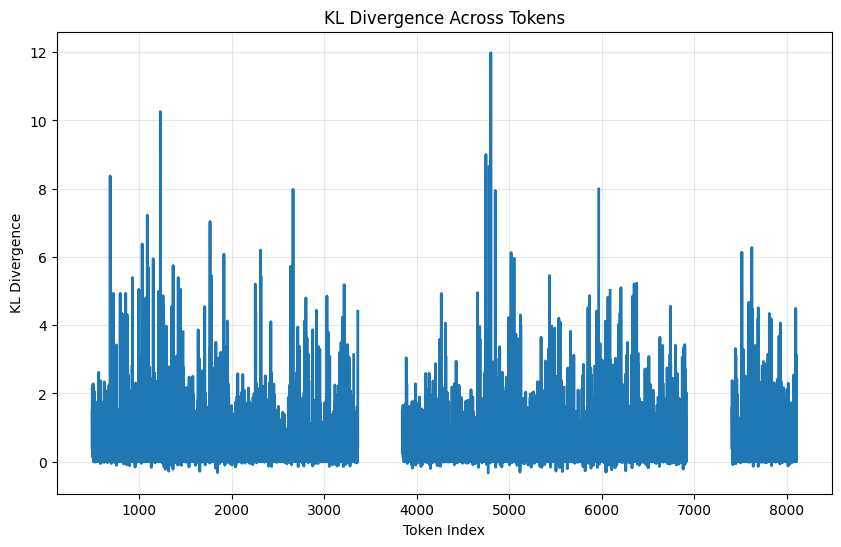

First token with KL divergence > 10: 1231
Token: 98996
Logprob: -0.0048474413342773914
New Logprob: -10.3125


ValueError: KL Divergence Debugging

In [62]:
await trainer.tune(explore_result)

In [64]:
tensors = explore_result.tensors()
display(tensors["tokens"][0][:1233])
tensors["logprobs"][0][:1233]

tensor([128000, 128002,    882,  ...,  28877,     25,  98996])

tensor([        nan,         nan,         nan,  ..., -2.1458e-06,
         0.0000e+00, -4.8474e-03])

In [67]:
trainer.tokenizer.decode(tensors["tokens"][0][1200:1233])

' when asked by Alexandria.\n\nPutting it all together, the facedown cards in the center of the table are:\n\n* Suspect: Madame Rose\n* Weapon: Rope'

: 

In [11]:
from openai import AsyncOpenAI

completion_sampler = await trainer.get_completion_sampler()
client: AsyncOpenAI = completion_sampler.samplers[0].client  # type: ignore

In [ ]:
vllm.client.chat.completions.create()

In [ ]:
from typing import Any

episode = explore_result.episodes[0]
completion = next(iter(episode.completion.leaves()))
tokens = completion.all_tokens(trainer.tokenizer, cache=True).tolist()
plain_completion = await vllm.client.completions.create(
    model=trainer.model,
    prompt=tokens,
    max_tokens=1,
    extra_body={
        "prompt_logprobs": True,
    },
)
prompt_logprobs: list[dict[str, dict[str, Any]]] = plain_completion.choices[0].prompt_logprobs  # type: ignore
prompt_logprobs

In [56]:
assert len(prompt_logprobs) == len(tokens)

In [ ]:
reference_logprobs = [
    prompt_logprob[str(token)]["logprob"] if prompt_logprob else torch.nan
    for token, prompt_logprob in zip(tokens, prompt_logprobs)
]
for c in completion.ancestors(including_self=True, reverse=True):
    count = c.token_count(trainer.tokenizer, cache=True)
    c.reference_logprobs, reference_logprobs = (
        torch.tensor(reference_logprobs[:count]),
        reference_logprobs[count:],
    )

completion.reference_logprobs

In [ ]:
sum(c._reference_logprobs.shape[0] for c in completion.ancestors(including_self=True))

In [ ]:
torch.tensor(
    [
        prompt_logprob[str(token)]["logprob"] if prompt_logprob else torch.nan
        for token, prompt_logprob in zip(tokens, prompt_logprobs)
    ]
)

In [ ]:
len(prompt_logprobs), len(completion.all_tokens(trainer.tokenizer, cache=True).tolist())

In [ ]:
import pickle

with open("/tmp/err_execute_model_input_20241201-005319.pkl", "rb") as f:
    data = pickle.load(f)

data

In [ ]:
list(data)

In [34]:
getattr(plain_completion, "prompt_logprobs", None)

In [ ]:
plain_completion.choices[0].prompt_logprobs

In [ ]:
completion.all_tokens(trainer.tokenizer, cache=True).tolist()

In [ ]:
plain_completion

In [10]:
trainer.patience_per_val_sample = 1.0
trainer.patience_per_test_sample = 1.0
trainer.tune_recipe_config.optimizer.lr = 8e-6
trainer.tune_recipe_config.loss.clip_epsilon = 0.1
trainer.tune_recipe_config.loss.weighted_ce_coef = 0.2

In [ ]:
await trainer.train(iterations=3)

In [ ]:
trainer.eval_scores

In [5]:
from lib.rl.pack import packed_tensors_from_dir

tensors = packed_tensors_from_dir(
    dir="./models/rl/tensors", num_sequences=50, sequence_length=16384
)

In [ ]:
tensors["mask"][0][2][2]

In [ ]:
trainer.max_mask_sequence_batch_size = 16
# (eval_score, eval_exceptions),
(result,) = await asyncio.gather(
    # trainer.eval("val", 0, return_exceptions=True),
    trainer.explore(1, return_exceptions=True),
)
# print(f"Eval score: {eval_score:.2%}")
print(
    f"Generated {sum(completion.num_token_logprobs() for episode in result.episodes for completion in episode.completion.descendants()):,} tokens"
)
tensors = trainer.tensors(result.episodes)
(tensors["mask"] == result.tensors()["mask"]).all()

In [ ]:
tensors = trainer.tensors(result.episodes)
(tensors["mask"] == result.tensors()["mask"]).all()

In [ ]:
torch.tensor(tensors["advantages"].shape).prod()

In [ ]:
tensors["mask"].shape

In [ ]:
import matplotlib.pyplot as plt
import torch


def show(mask: torch.Tensor) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap="inferno")
    plt.colorbar(label="Relative Position")
    plt.title("Relative Position Attention Mask")
    plt.xlabel("Target Position")
    plt.ylabel("Source Position")
    plt.show()


i = 1
_tensors = tensors
key = "input_pos"

show(
    _tensors["mask"][i].cumsum(dim=1)
    * (
        _tensors["mask"][i]
        & (
            ~torch.isnan(_tensors[key][i]).unsqueeze(0)
            & ~torch.isnan(_tensors[key][i]).unsqueeze(1)
        )
    )
)

In [ ]:
result.tensors()["mask"].shape

In [ ]:
(tensors["mask"] == result.tensors()["mask"]).all()

In [ ]:
for i in range(127):
    for j in range(127):
        if (tensors["mask"][i] == result.tensors()["mask"][j]).all():
            print(i, j)

In [ ]:
key = "advantages"
torch.isclose(
    tensors[key], result.tensors()[key], rtol=1e-5, atol=1e-8, equal_nan=True
).all()

In [ ]:
torch.all((tensors["weights"] == result.tensors()["weights"]))

In [ ]:
raise result.exceptions[1]

In [ ]:
result.exceptions

In [ ]:
2_033_717 / 4.25

In [ ]:
2_064_056 / 6.66

In [ ]:
2_064_056 / 10.75

In [ ]:
2_071_601 / 8

In [ ]:
2_071_601 / 11.75

In [ ]:
4_119_041 / 16.5

In [ ]:
await trainer.train(iterations=1)

In [ ]:
val_score, episodes = await asyncio.gather(trainer.eval("val", 0), trainer.explore(1))

In [ ]:
from torchtune.models.llama3_1 import llama3_1_8b
from torchtune.training import cleanup_before_training
from torchtune.training.metric_logging import DiskLogger
from typing import Any

from lib.recipes.rl import ComponentConfig, RLConfig, RLRecipe
from lib.rl.pack import PackedDataset, packed_tensors_to_dir
from lib.rl.ppo import PPOLoss


tensors, checkpoint_dir, checkpoint_files = await trainer.tune_resources(episodes)

PLACEHOLDER: Any = None

config = RLConfig(
    # Dataset
    dataset=ComponentConfig(
        PackedDataset, **packed_tensors_to_dir(tensors, trainer.output_dir + "/tensors")
    ),
    seed=42,
    shuffle=False,
    # Model
    model=ComponentConfig(llama3_1_8b),
    num_output_chunks=4,
    # Checkpointer
    checkpointer=ComponentConfig(
        "torchtune.training.FullModelHFCheckpointer",
        checkpoint_dir=checkpoint_dir,
        checkpoint_files=checkpoint_files,
        recipe_checkpoint=None,
        output_dir=trainer.output_dir,
        model_type="LLAMA3",
    ),
    resume_from_checkpoint=False,
    # Fine-tuning arguments
    batch_size=4,
    epochs=1,
    optimizer=ComponentConfig(
        "torch.optim.AdamW",
        # "bitsandbytes.optim.PagedAdamW8bit",
        # "bitsandbytes.optim.AdamW",
        # params=PLACEHOLDER,
        lr=5e-6,
        fused=True,
    ),
    loss=ComponentConfig(
        PPOLoss,
        # clip_epsilon=0.3,
        # entropy_coef=0.0,
        # kl_coef=0.0,
        clip_epsilon=0.3,
        entropy_coef=0.025,
        kl_coef=0.025,
        normalize_advantages=False,
    ),
    max_steps_per_epoch=None,
    compile=False,
    optimizer_in_bwd=False,
    gradient_accumulation_steps=1,
    # Training env
    device="cuda",
    # Memory management
    enable_activation_checkpointing=True,
    enable_activation_offloading=False,
    custom_sharded_layers=["tok_embeddings", "output"],
    # Reduced precision
    dtype="bf16",
    # Logging
    metric_logger=ComponentConfig(
        DiskLogger, log_dir="/home/ubuntu/atreides/experiments/logs"
    ),
    log_every_n_steps=1,
    log_peak_memory_stats=True,
)

# recipe = RLRecipe(config)
# recipe.setup(config)
# recipe.train()
# recipe.cleanup()
# del tensors, recipe
# cleanup_before_training()
# trainer.save(base_checkpoint_dir=checkpoint_dir)

In [19]:
from omegaconf import OmegaConf

dict_config = config.dict_config()
OmegaConf.save(dict_config, trainer.output_dir + "/config.yaml")

In [ ]:
import os
import sys
from typing import IO

torchrun_kwargs = {"nnodes": 1, "nproc_per_node": 2}
kwargs = {}
env = {"CUDA_LAUNCH_BLOCKING": "1"}

args = [
    "tune",
    "run",
    *[
        f"--{key.replace('_', '-')}{f'={value}' if value is not True else ''}"
        for key, value in torchrun_kwargs.items()
    ],
    "lib.recipes.rl.RLRecipe",
    "--config",
    trainer.output_dir + "/config.yaml",
    *[
        f"--{key.replace('_', '-')}{f'={value}' if value != True else ''}"
        for key, value in kwargs.items()
    ],
]
print(f"$ {' '.join(args)}")

In [ ]:
process = await asyncio.create_subprocess_exec(
    *args,
    stdout=asyncio.subprocess.PIPE,
    stderr=asyncio.subprocess.PIPE,
    env={
        **os.environ,
        **(env or {}),
    },
)


async def log_output(stream: asyncio.StreamReader, io: IO[str]) -> None:
    while True:
        line = await stream.readline()
        if not line:
            break
        decoded_line = line.decode()
        io.write(decoded_line)
        io.flush()


tasks = []
if process.stdout:
    tasks.append(asyncio.create_task(log_output(process.stdout, sys.stdout)))
if process.stderr:
    tasks.append(asyncio.create_task(log_output(process.stderr, sys.stderr)))
_ = await asyncio.gather(*tasks)

In [ ]:
from lib.recipes.rl import recipe_main
import os
from torch import distributed as dist
from torchtune.training import is_distributed

os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29500"
os.environ["WORLD_SIZE"] = "1"
os.environ["RANK"] = "0"


recipe_main(config)

In [7]:
from omegaconf import DictConfig, OmegaConf

dict_config = config.dict_config()
OmegaConf.save(dict_config, trainer.output_dir + "/config.yaml")

In [ ]:
from lib.rl.completion import Completion


OmegaConf.create(
    OmegaConf.to_yaml(
        DictConfig(dict(name=f"{Completion.__module__}.{Completion.__name__}"))
    )
)

In [27]:
import traceback
import sys

traceback.clear_frames(sys.exc_info()[2])

In [28]:
cleanup_before_training()

In [ ]:
trainer.save(base_checkpoint_dir=checkpoint_dir)

In [ ]:
import matplotlib.pyplot as plt
import torch


def show(mask: torch.Tensor) -> None:
    plt.figure(figsize=(10, 10))
    plt.imshow(mask, cmap="inferno")
    plt.colorbar(label="Relative Position")
    plt.title("Relative Position Attention Mask")
    plt.xlabel("Target Position")
    plt.ylabel("Source Position")
    plt.show()


i = 1

show(
    tensors["mask"][i].cumsum(dim=1)
    * (
        tensors["mask"][i]
        & (
            ~torch.isnan(tensors["advantages"][i]).unsqueeze(0)
            & ~torch.isnan(tensors["advantages"][i]).unsqueeze(1)
        )
    )
)

In [ ]:
from IPython.display import HTML

HTML(
    f'<div style="white-space: pre-wrap">{list(episodes[2].completion.leaves())[0].html(30.0)}</div>'
)

In [ ]:
def mask_and_pos_ids(
    ids: torch.Tensor, parent_ids: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:
    """Creates an attention mask and position IDs for hierarchical attention based on node IDs and their parent IDs.

    Args:
        ids: A tensor of shape (batch_size, sequence_length) containing node IDs
        parent_ids: A tensor of shape (batch_size, sequence_length) containing parent IDs for each node

    Returns:
        A tuple containing:
        - mask: A boolean tensor of shape (batch_size, sequence_length, sequence_length) where True indicates
          allowed attention connections. Each position can attend to itself and any of its ancestors
          in the hierarchy, but only for previous positions (due to causal masking).
        - pos_ids: A tensor of shape (batch_size, sequence_length, sequence_length) containing relative
          position IDs for each allowed attention connection, with -1 for masked positions.
    """
    mask = ids.unsqueeze(1) == ids.unsqueeze(2)
    _mask = mask | (ids.unsqueeze(1) == parent_ids.unsqueeze(2))
    while torch.any(mask != _mask):
        parent_ids = parent_ids.gather(
            1, torch.argmax((parent_ids.unsqueeze(2) == ids.unsqueeze(1)).int(), dim=2)
        )
        mask = _mask
        _mask = mask | (ids.unsqueeze(1) == parent_ids.unsqueeze(2))
    mask &= torch.tril(torch.ones_like(mask, dtype=torch.bool, device=ids.device))
    # mask = torch.linalg.matrix_power(mask.float(), mask.size(1) - 1) > 0
    pos_ids = (torch.where(mask, mask.cumsum(2), 0) - 1).max(1).values
    return mask, pos_ids


def test_mask_and_pos_ids(
    ids: list[int],
    parent_ids: list[int],
    expected_mask: list[list[int]],
    expected_pos_ids: list[int],
):
    mask, pos_ids = mask_and_pos_ids(
        ids=torch.tensor([ids]), parent_ids=torch.tensor([parent_ids])
    )
    assert torch.all(mask.int() == torch.tensor([expected_mask])), f"\n{mask.int()[0]}"
    assert torch.all(
        pos_ids == torch.tensor([expected_pos_ids])
    ), f"{pos_ids[0].tolist()}"


test_mask_and_pos_ids(
    ids=[0, 1],
    parent_ids=[0, 1],
    expected_mask=[[1, 0], [0, 1]],
    expected_pos_ids=[0, 0],
)

test_mask_and_pos_ids(
    ids=[0, 1, 1],
    parent_ids=[0, 0, 0],
    expected_mask=[[1, 0, 0], [1, 1, 0], [1, 1, 1]],
    expected_pos_ids=[0, 1, 2],
)

test_mask_and_pos_ids(
    ids=[0, 1, 2, 3],
    parent_ids=[0, 0, 1, 2],
    expected_mask=[[1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 0], [1, 1, 1, 1]],
    expected_pos_ids=[0, 1, 2, 3],
)

test_mask_and_pos_ids(
    ids=[0, 0, 1, 1],
    parent_ids=[0, 0, 1, 1],
    expected_mask=[[1, 0, 0, 0], [1, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 1]],
    expected_pos_ids=[0, 1, 0, 1],
)

test_mask_and_pos_ids(
    ids=[0, 1, 2, 3],
    parent_ids=[0, 1, 0, 1],
    expected_mask=[[1, 0, 0, 0], [0, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1]],
    expected_pos_ids=[0, 0, 1, 1],
)

test_mask_and_pos_ids(
    ids=[0, 1, 2, 2, 3, 3],
    parent_ids=[0, 1, 0, 0, 1, 1],
    expected_mask=[
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [1, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 1, 1],
    ],
    expected_pos_ids=[0, 0, 1, 2, 1, 2],
)

test_mask_and_pos_ids(
    ids=[0, 1, 2, 3, 4, 4, 5, 5],
    parent_ids=[0, 0, 1, 1, 2, 2, 3, 3],
    expected_mask=[
        [1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 0],
        [1, 1, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 1, 1],
    ],
    expected_pos_ids=[0, 1, 2, 2, 3, 4, 3, 4],
)

test_mask_and_pos_ids(
    ids=[2, 1, 0],
    parent_ids=[2, 2, 0],
    expected_mask=[
        [1, 0, 0],
        [1, 1, 0],
        [0, 0, 1],
    ],
    expected_pos_ids=[0, 1, 0],
)